# Credit Card Fraud Detection

[Dataset](https://drive.google.com/file/d/1CTAlmlREFRaEN3NoHHitewpqAtWS5cVQ/view)

[ADASYN Paper](http://scholar.google.com/scholar_url?url=https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2008-He-ieee.pdf&hl=en&sa=X&scisig=AAGBfm1uJ1FIWcOyYTHBq1effUALxWAmHg&nossl=1&oi=scholarr)

[SMOTE Paper](https://arxiv.org/pdf/1106.1813)


In [1]:
# load libraries --------------------------------------------

# essentials
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import time
from collections import Counter
import pickle

# data prep
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#update some display settings
from IPython.display import display
pd.options.display.max_columns = None


#plotting format details
SMALL_SIZE = 8
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rcdefaults()
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

# choose a plotting theme
# plt.xkcd()
# plt.style.use('fivethirtyeight')


C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# load all helper functions
def make_heatmap(df):
    """
    ~~Inputs~~
    df = pandas data frame (filtered to only include the columns that you want to examine)
    """
    # make a heat map to show correlation of flags with zp
    corr_fields=df.columns
    temp_df = df#[corr_fields]
    corr = temp_df.corr()

    # plot the heatmap
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap = 'YlOrRd')
    return

def train_model(model,X,y):
    """given data and a model, train and print out metrics
    """
    print('Training Model ...')
    train_start = time.time()
    model.fit(X,y)
    train_end = time.time()
    print('Training complete in', np.round(train_end-train_start,4), 'seconds.')
    return model

def display_results(model, test_X, test_y):
    """display some of the basic metrics to evaluate a trained classification model
    """
    preds = model.predict(test_X)
    accuracy = accuracy_score(test_y, preds)
    print(f"Accuracy:{np.round(accuracy, 4)}")
    
    cnf_matrix = confusion_matrix(test_y,preds)
    clean_conf_mat = pd.DataFrame(cnf_matrix)
    clean_conf_mat.columns=['Predicted_0','Predicted_1']
    clean_conf_mat.insert(0,'Label',['Actual_0','Actual_1'])
    
    prec = cnf_matrix[1,1] / (cnf_matrix[0,1] + cnf_matrix[1,1])
    recall = cnf_matrix[1,1] / (cnf_matrix[1,1] + cnf_matrix[1,0])
    print(f"Precision: {np.round(prec,4)}")
    print(f"Recall: {np.round(recall,4)}")
    
    return clean_conf_mat

# Data

There are a few things about the dataset that are worth noting:
- It is available for download at the link included at the top of this notebook
- The values v1 to v28 are the results of PCA dimension reductions to protect sensitive information like user identities. (According to data provider)
- Other descriptions of the data are limited (There are columns for `Time` and `Amount`, but no details as to how exactly these values were recorded or details about if they have been standardized

I start out by reading in the data and doing some basic exploratory analysis. 

- There are about 284k observations made up of continuous variables only, no categorical variables outside of the response variable (fraud or not fraud)
- 30 explanatory variables total

In [3]:
# read in the data
data = pd.read_csv("creditcard.csv")
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


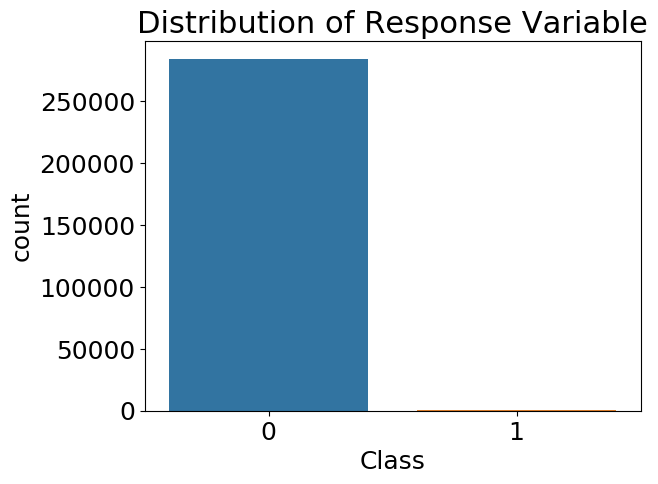

Percentage of Fraud: 0.1727485630620034
Count of Fraud: 492


In [6]:
# what does the response variables look like
plt.title("Distribution of Response Variable")
sns.countplot(x='Class', data=data)
plt.show()
print("Percentage of Fraud:",100 * data['Class'].mean())
print("Count of Fraud:",data['Class'].sum())

The plot above shows that this data set (as are virtually all fraud detection datasets) is extremely imbalanced. There is only a small percentage of transactions that are fraudulent. This is something that I will have to take into account when I build a model.

## Feature Exploration

I find that understanding feautre distributions is often the most helpful method to help me understand the details of a dataset. 
Below I made histograms/density plots of each of the features to better understand their distribution

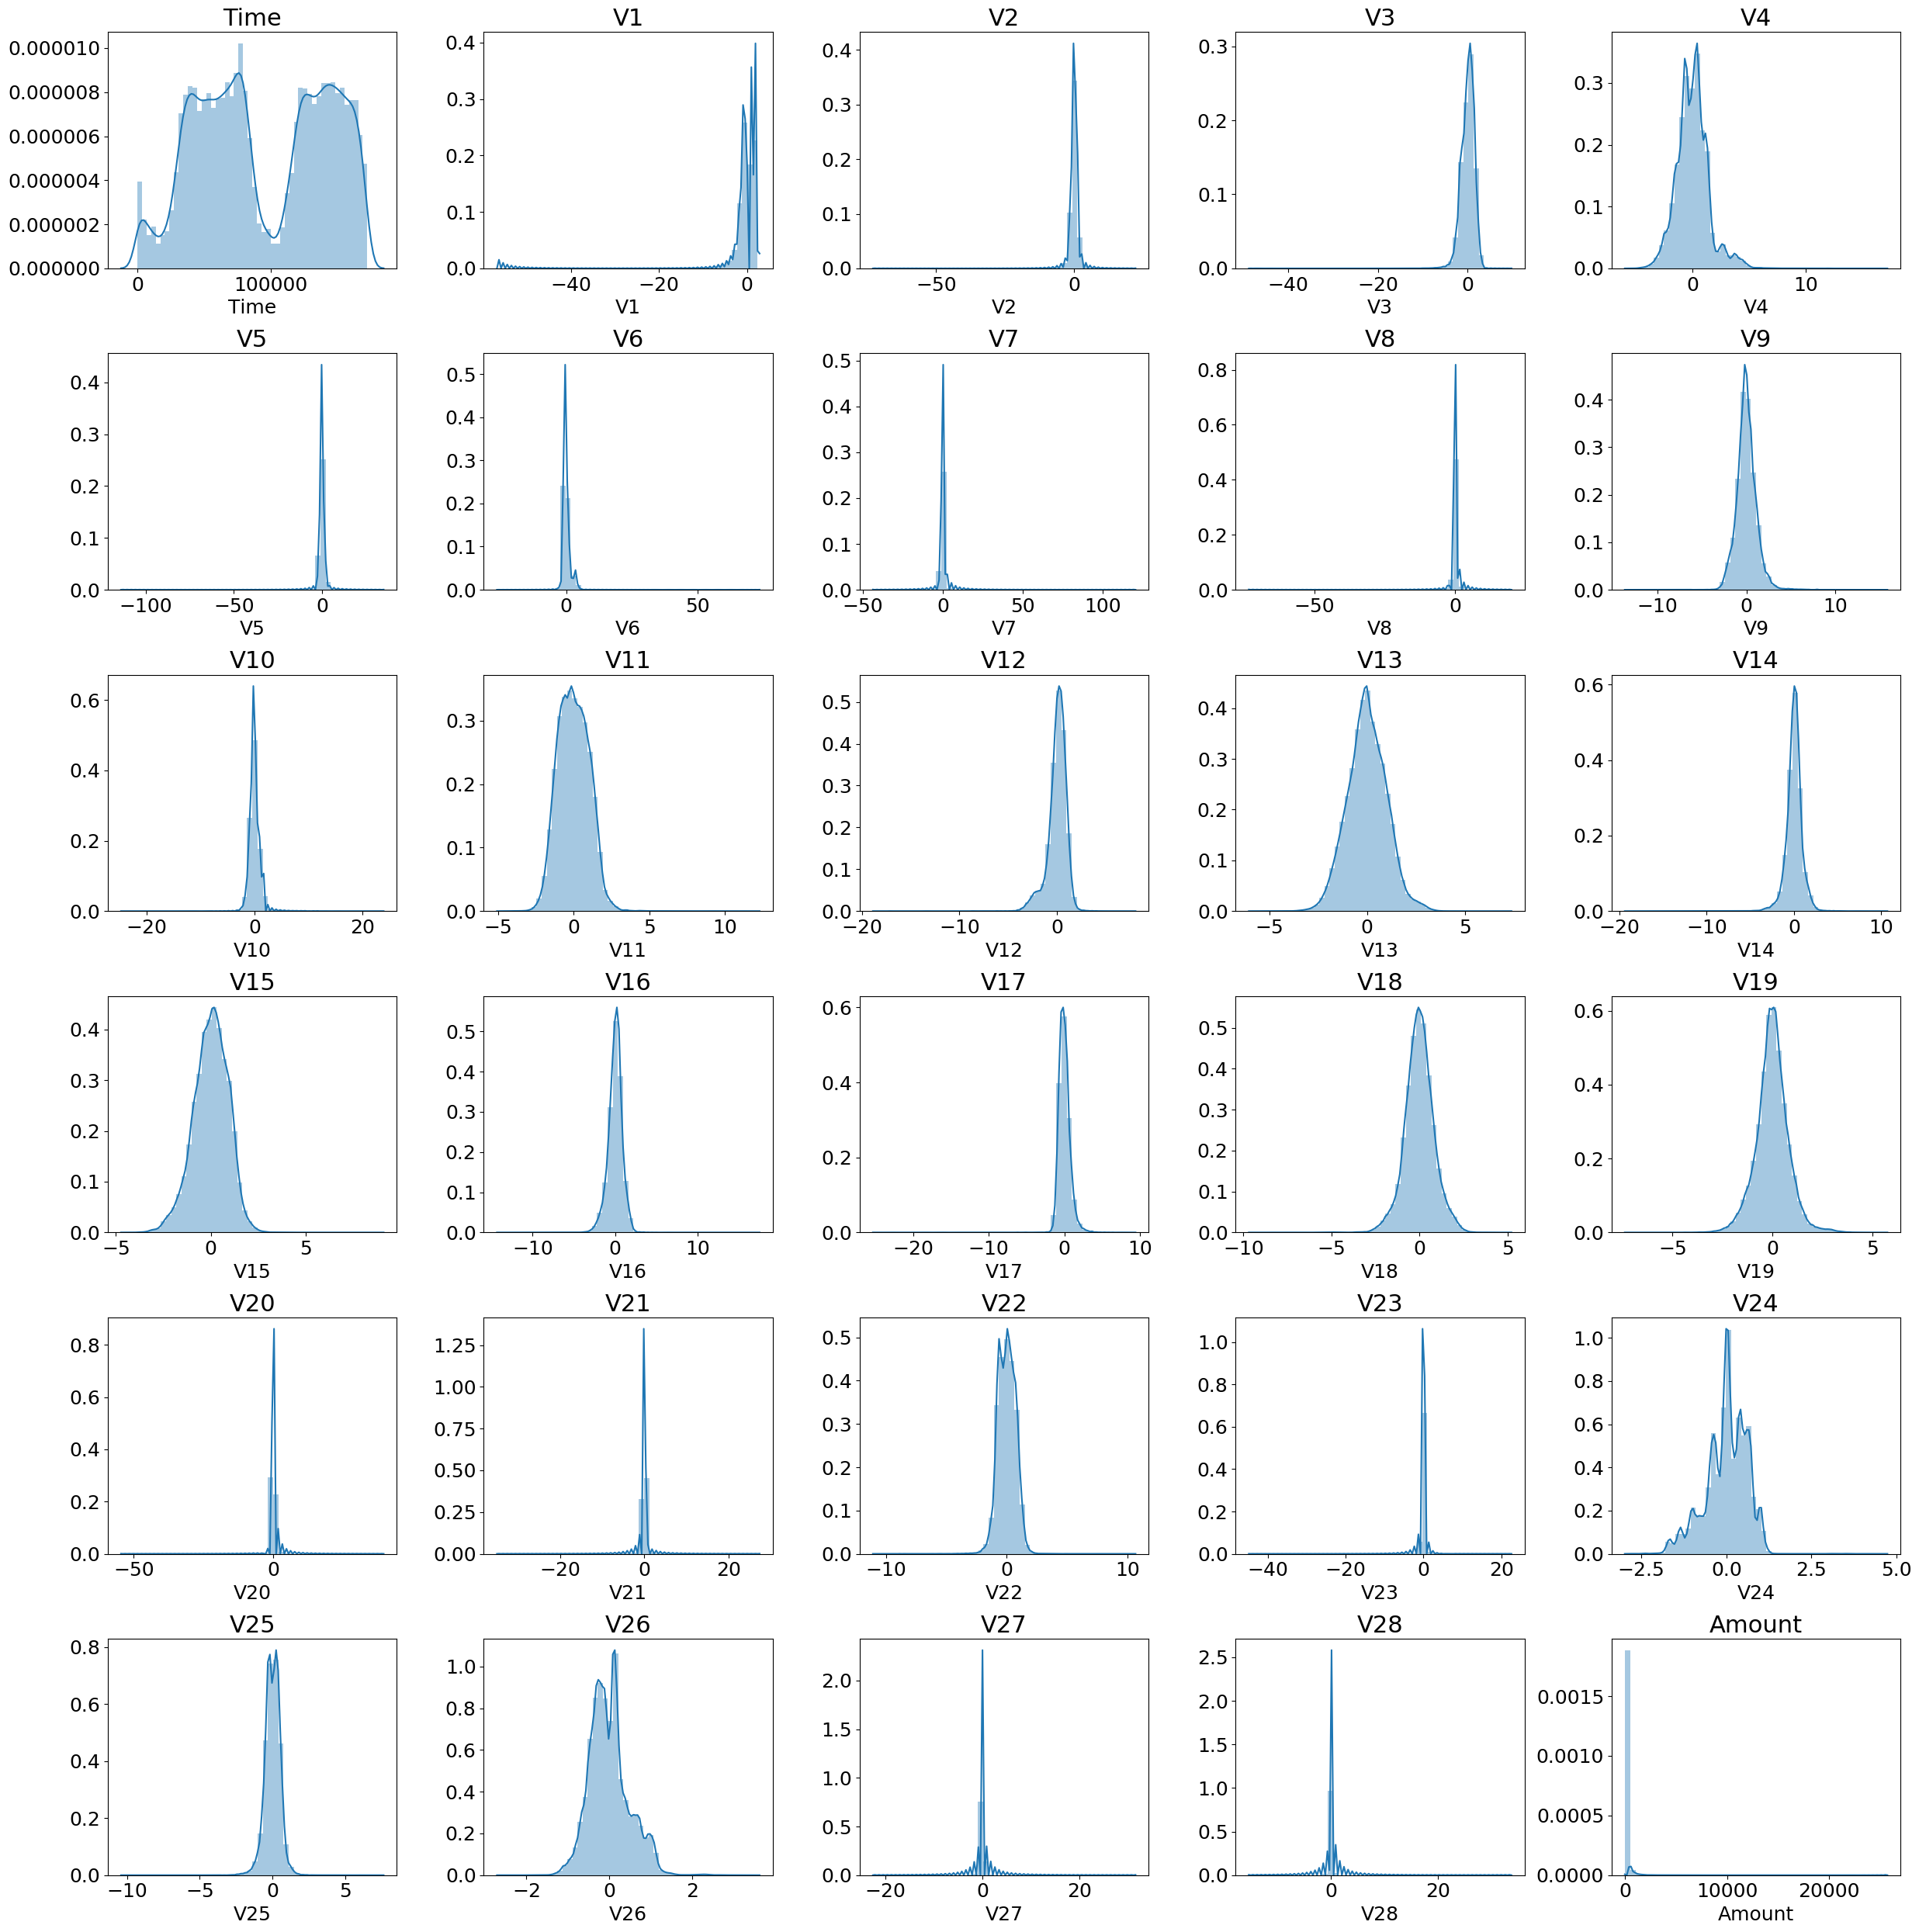

In [7]:
# make histograms for all features
nrow = 6
ncol = 5
plt.figure(figsize=(25,25))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(nrow, ncol, i + 1)
#     plt.hist(data[col])
    sns.distplot(data[col])
#     sns.distplot(data[][col])
    plt.title(col)

plt.tight_layout()
plt.show()
plt.close()



Looking at the histograms above, it seems that there are a lot of features that are relatively low variance features. These features may be less useful for the model, but they still may contain some useful information

I am particularly intrigued by the bimodal distribution of the time variable. However, this makes sense given that customer activity is heaviest in the mornings/evenings when people aren't at work, and customer activity is probably very light during the late night hours. 

Below I used a violin plot to compare the distrubtion of the `Time` feature between fraud and non-fraud populations. We can see that the distributions are different and that the density of fraud seems to be higher in the deepest valley of the non-fraud population. Perhaps fraudsters are more active at night while their ID theft victims are asleep?

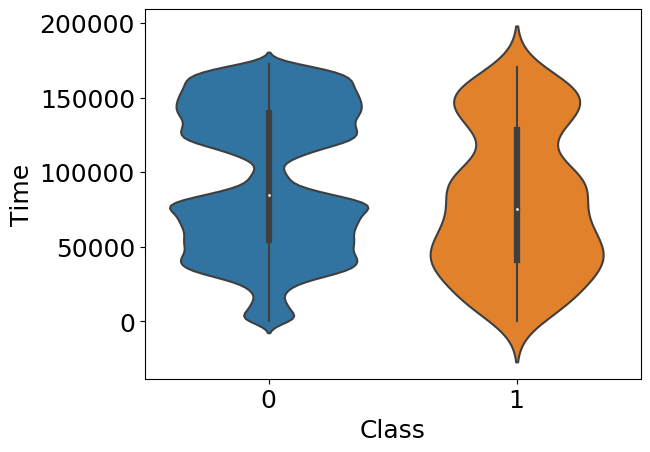

In [8]:
sns.violinplot(x='Class',y='Time', data=data)
plt.show()

#### Feature Exploration with Box Plots

Box plots are a great way to examine relationships between categorical and continuous features. In this case, the response variable is categorical and all of the features are continuous which means that we can set up all of our boxplots with a simple `for` loop

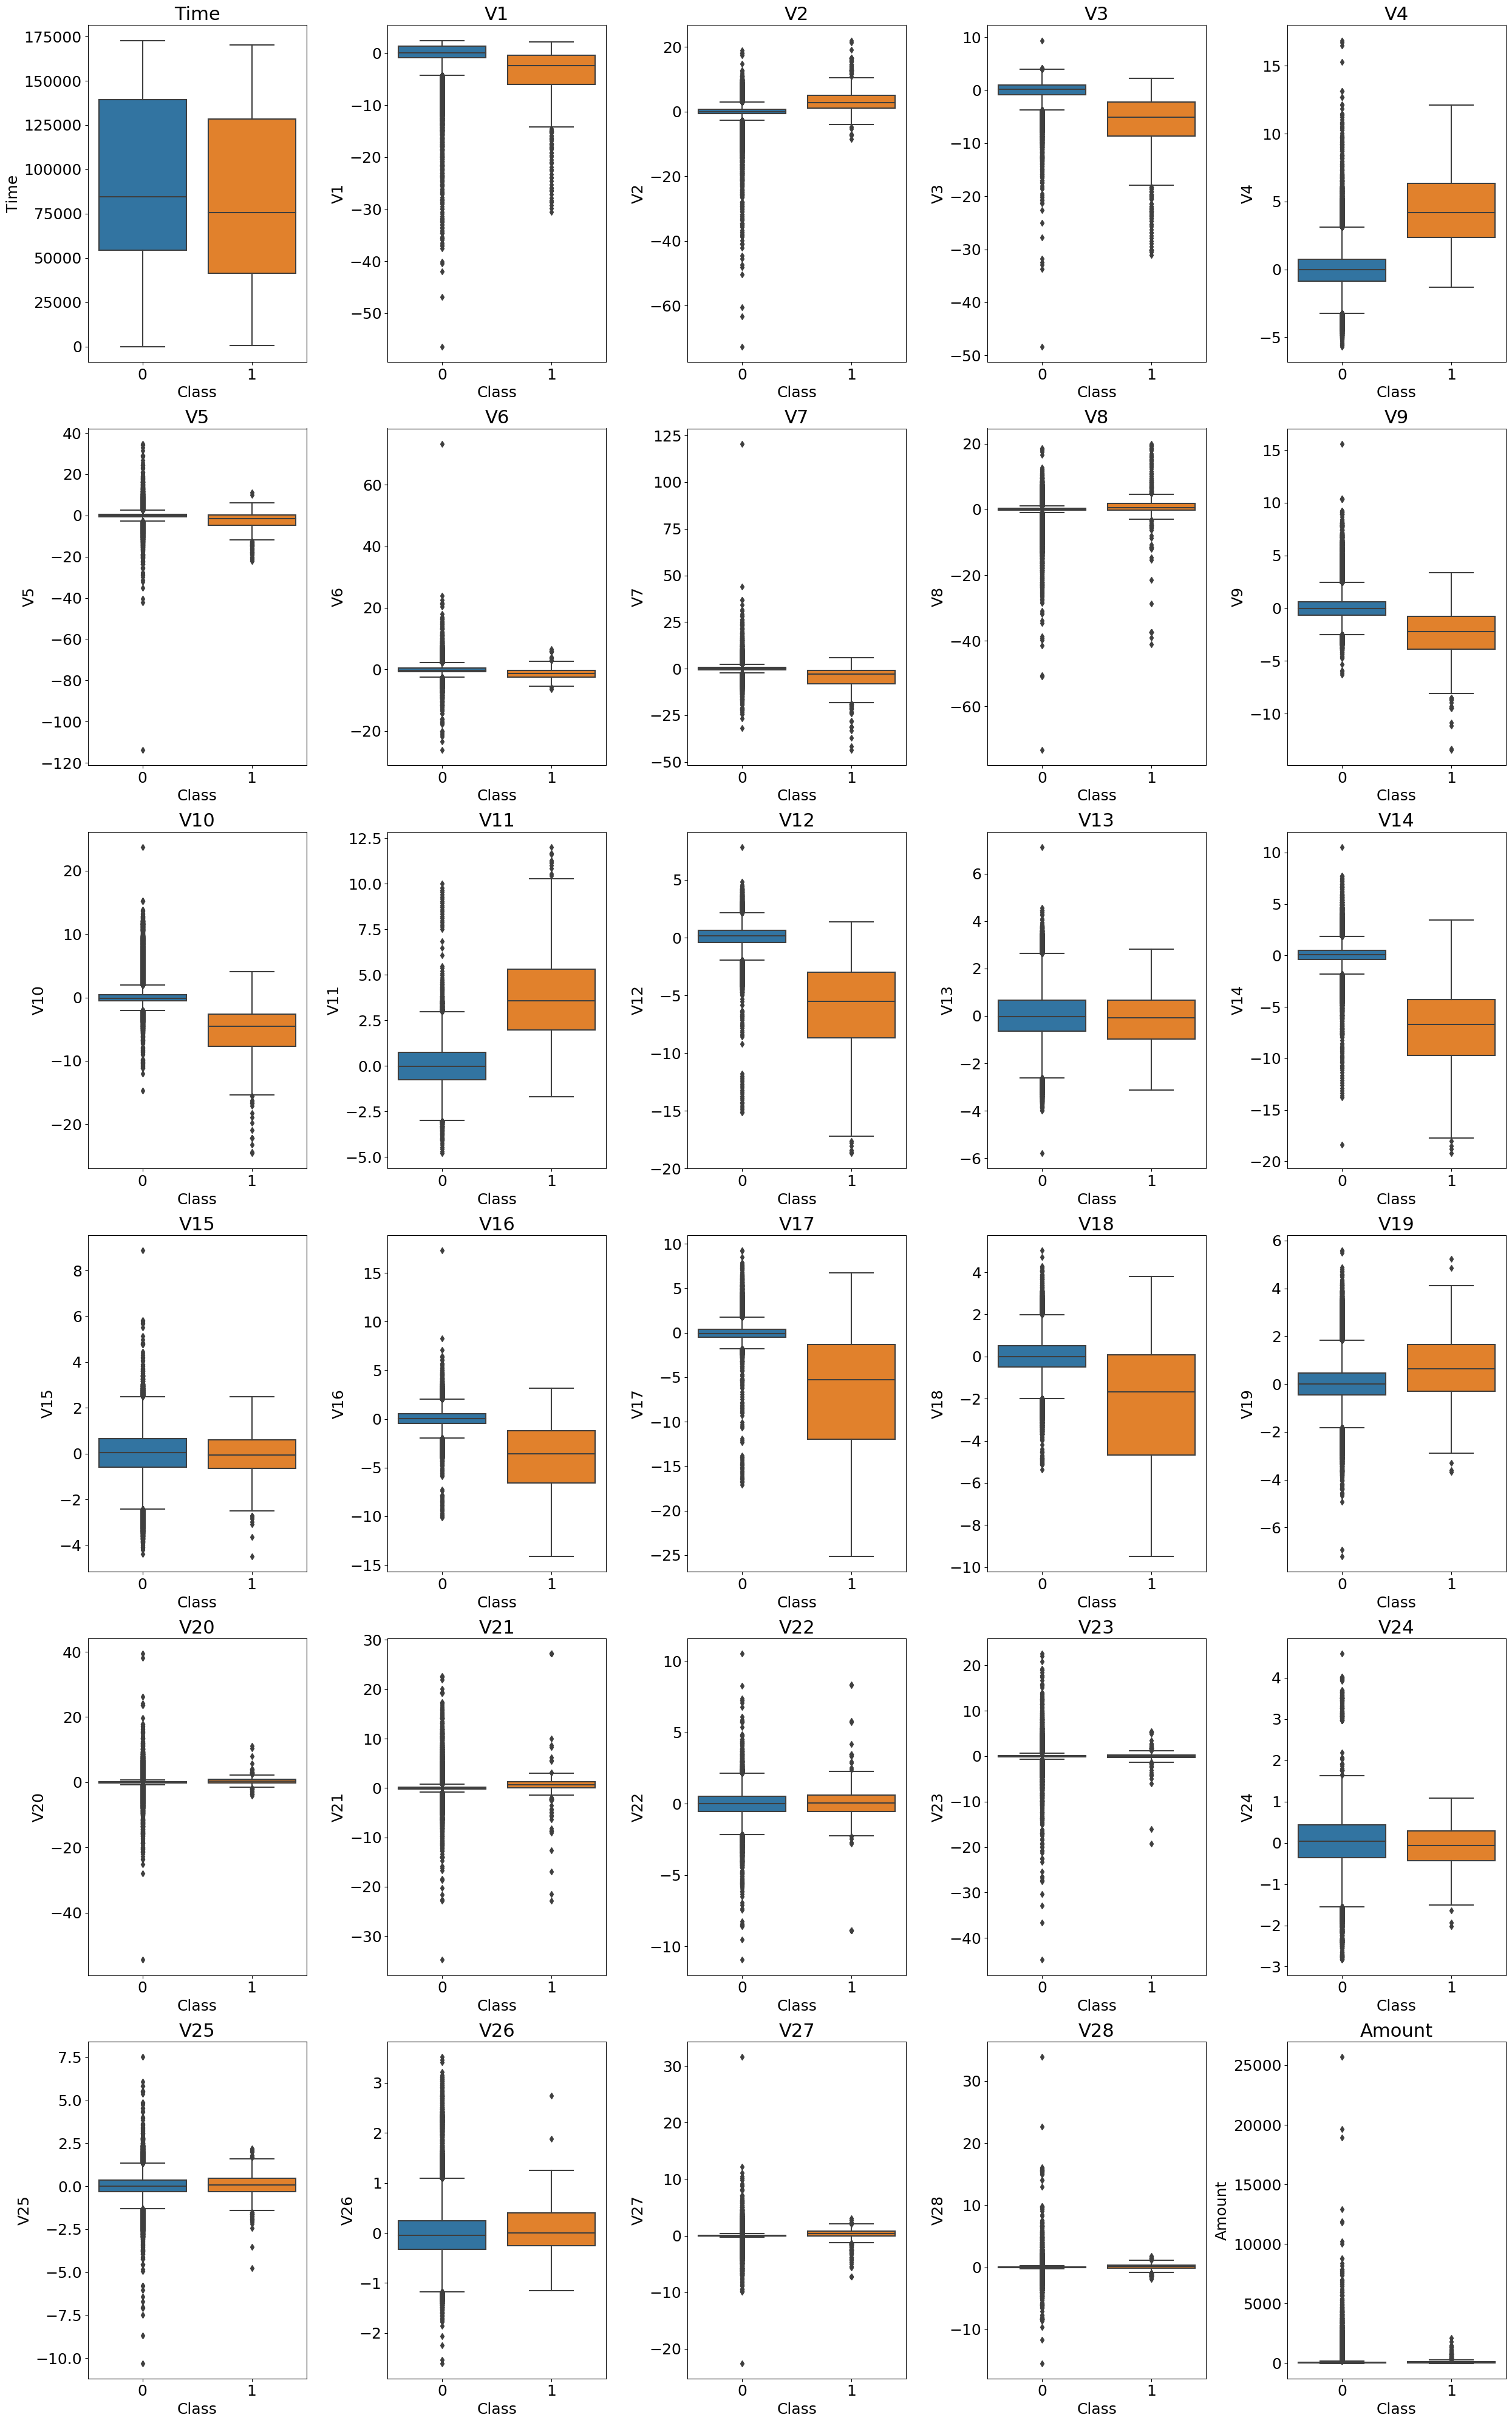

In [9]:
# make box plots for all features
nrow = 6
ncol = 5
plt.figure(figsize=(25,40))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(nrow, ncol, i + 1)
    sns.boxplot(x = 'Class', y = col, data = data)
    plt.title(col)

plt.tight_layout()
plt.show()
plt.close()



Based on the Box plots above, we can see that several features seem to have a significant relationship with the response variable. Check out the boxplots for `V11`, `V12`, `V14`, `V17`, and `V18`, just to name a few.

#### Building a Heatmap of feature correlations
The next things I do is create a heatmap of all the feature correlations. This will show me if any of the features should be removed since they are highly correlated with another feature. 


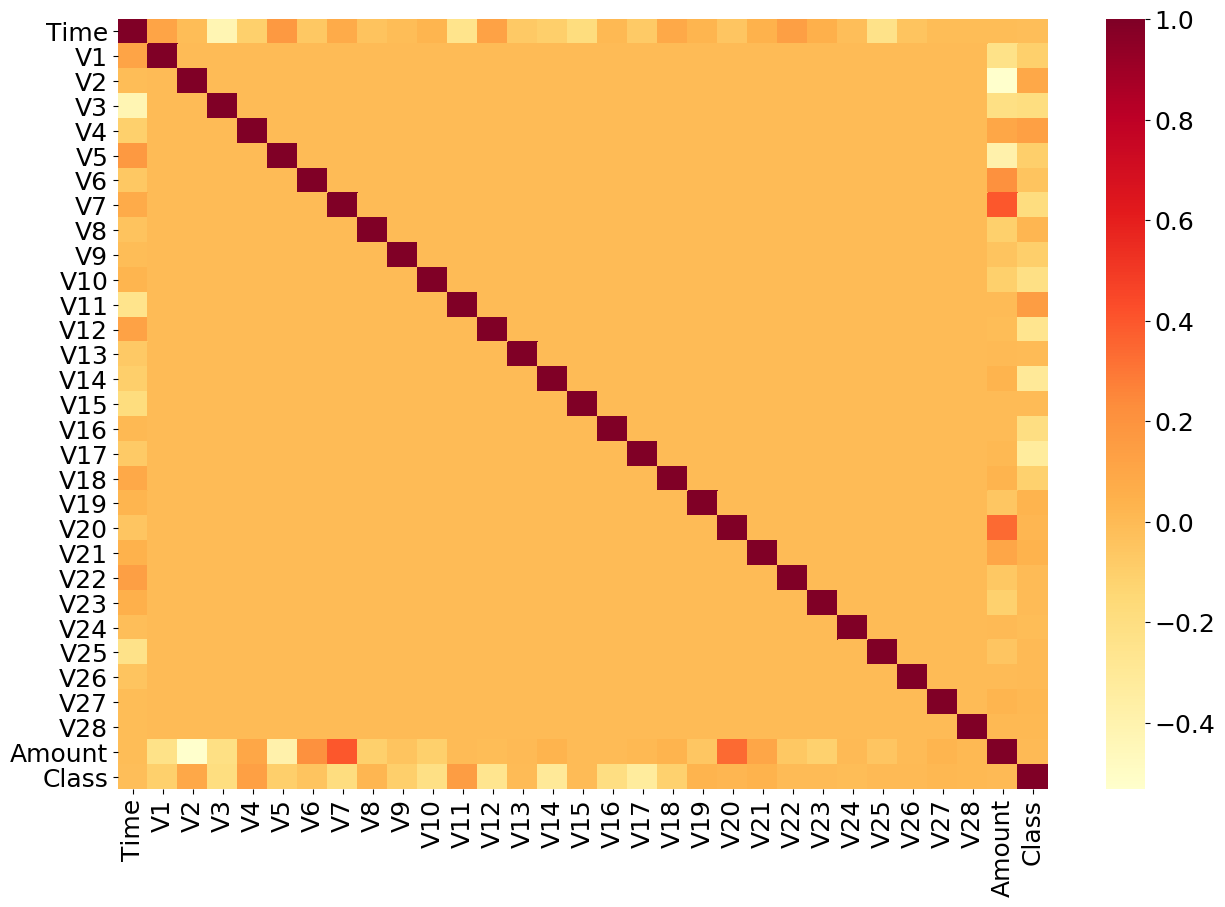

In [10]:
# how are the features correlated with each other
make_heatmap(data)

It looks like none of the features are too strongly correlated with eachother, so I will choose to use all of these features when building out my models

## Make Train and Test Sets

The next thing I do is split the data into train and test sets. I chose to have 80% of the data be used for training, and 20% used for testing.

In [11]:
# pause the notebook
# assert False

In [12]:
_RANDOM_STATE_ = 0
X_train, X_test, y_train, y_test = train_test_split(data.drop('Class',axis=1),
                                                    data['Class'],
                                                    test_size=0.2,
                                                    random_state=_RANDOM_STATE_
)

print(f"Training Set Dimensions:{X_train.shape}")
print(f"Testing Set Dimensions:{X_test.shape}")
print()
print("Response Distribution for Train/Test sets:")
print(f"Percent Fraud of Train Set: {100 * np.mean(y_train)}")
print(f"Percent Fraud of Test Set: {100 * np.mean(y_test)}")
print()
print(f"Fraud Count of Train Set: {Counter(y_train)}")
print(f"Fraud Count of Test Set: {Counter(y_test)}")

Training Set Dimensions:(227845, 30)
Testing Set Dimensions:(56962, 30)

Response Distribution for Train/Test sets:
Percent Fraud of Train Set: 0.171607891329632
Percent Fraud of Test Set: 0.1773111899160844

Fraud Count of Train Set: Counter({0: 227454, 1: 391})
Fraud Count of Test Set: Counter({0: 56861, 1: 101})


Looking at the results above, I'm satisfied with this train test split because it did a good job of maintaining the balance of the response variable across the train/test sets.

### Establishing a Benchmark
To determine if our end results is good, we need to first establish a benchmark. I will use to strategies to build a benchmark:
- the first strategy is simply predicting that everything is not fraud. This is will result in a high overall accuracy due to the class imbalance, but will at least give us a reference point
- the second thing I do is build out an 'Out-of-the-box' logistic regression model. This model is among the more basic classification models and should provide another good reference point as we try to build out more advanced solutions. 

#### Bench Mark 1: Predicting that everything is not fraud

In [13]:
# Bench Mark 1: Predicting that everything is not fraud
print("Benchmark 1")
accuracy = accuracy_score(y_test, [0] * len(y_test))
print(f"Accuracy:{np.round(accuracy, 4)}")

bench_matrix1 = pd.DataFrame(confusion_matrix(y_test,[0] * len(y_test)))
bench_matrix1.columns=['Predicted_0','Predicted_1']
bench_matrix1.insert(0,'Label',['Actual_0','Actual_1'])
bench_matrix1

Benchmark 1
Accuracy:0.9982


,Label,Predicted_0,Predicted_1
0,Actual_0,56861,0
1,Actual_1,101,0


#### Benchmark 2: Out of the Box Logistic Regression Model

In [14]:
log_reg = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(log_reg, X_train, y_train)
display_results(log_reg,X_test,y_test)

Training Model ...
Training complete in 4.4514 seconds.
Accuracy:0.999
Precision: 0.734
Recall: 0.6832


C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Label,Predicted_0,Predicted_1
0,Actual_0,56836,25
1,Actual_1,32,69


The warning shows that the benchmark model failed to converge (which is probably due in part to the large class imbalance). The accuracy, however, is still better than 1st benchmark or simply predicting everything as non-fraud. The benchmark logistic regression model captured 69 of the 101 total fraud leases in the test set. It had 25 false-positives, and 32 false-negatives.

## Handling the class imbalance

The bench marks above give us a reference point for what a very basic modeling approach can do. However, I still haven't done anything to account for the imbalance of classes  in the data. As a result, I will create one more bench mark model that uses `Random Over Sampling` to account for the class imbalance

In [15]:
# build a new dataset with ROS
ros = RandomOverSampler(random_state=_RANDOM_STATE_)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print(f"Training Set Dimensions:{X_ros.shape}")
print(f"Percent Fraud of Train Set: {100 * np.mean(y_ros)}")
print(f"Fraud Count of Train Set: {Counter(y_ros)}")


C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training Set Dimensions:(454908, 30)
Percent Fraud of Train Set: 50.0
Fraud Count of Train Set: Counter({0: 227454, 1: 227454})


In [16]:
log_reg2 = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(log_reg2, X_ros, y_ros)
display_results(log_reg2,X_test,y_test)

Training Model ...
Training complete in 5.811 seconds.
Accuracy:0.9627
Precision: 0.0417
Recall: 0.9109


,Label,Predicted_0,Predicted_1
0,Actual_0,54745,2116
1,Actual_1,9,92


Interesting. After accounting for the imbalance using ROS, the model was able to capture more of the fraudulent transactions, but it did so at the cost of many more false positives. I would say that this model is actually worse than when we didn't account for class imbalance. 

#### Other Strategies to Balance Data

There are many strategies for balancing data. I chose to use a few oversampling strategies to build out my solution. The other strategies I use on top of `Random Over Sampling` are:
- SMOTE
- ADASYN

The papers for the above methods are linked at the top of this notebook

In [17]:
# build out SMOTE Data set
sm = SMOTE(random_state=_RANDOM_STATE_)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

print(f"Training Set Dimensions:{X_smote.shape}")
print(f"Percent Fraud of Train Set: {100 * np.mean(y_smote)}")
print(f"Fraud Count of Train Set: {Counter(y_smote)}")

C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training Set Dimensions:(454908, 30)
Percent Fraud of Train Set: 50.0
Fraud Count of Train Set: Counter({0: 227454, 1: 227454})


In [18]:
# build out ADASYN Data set
adasyn = ADASYN(random_state=_RANDOM_STATE_)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

print(f"Training Set Dimensions:{X_adasyn.shape}")
print(f"Percent Fraud of Train Set: {100 * np.mean(y_adasyn)}")
print(f"Fraud Count of Train Set: {Counter(y_adasyn)}")

C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training Set Dimensions:(455014, 30)
Percent Fraud of Train Set: 50.011647993248566
Fraud Count of Train Set: Counter({1: 227560, 0: 227454})


## Exploring Different Models
In this next section, I'll explore a few different models to see if we can improve the results from our bench mark. After the inital results are examined, I will pick the top performing model (or two) and do some hyperparameter tuning to produce a final model.

I chose build 3 different kinds of models:
- Logisitic Regression (Baseline)
- ExtraTreesClassifier
- RandomTreesClassifier


For each model I examined the performance with multiple data balancing strategies:
- No Strategy (baseline)
- Random Over Sampling
- ADASYN
- SMOTE

#### ExtraTreesClassifier


In [19]:
extra_imbalance = ExtraTreesClassifier(random_state=_RANDOM_STATE_)
train_model(extra_imbalance, X_train, y_train)
display_results(extra_imbalance, X_test, y_test)

Training Model ...
Training complete in 30.472 seconds.
Accuracy:0.9995
Precision: 0.9512
Recall: 0.7723


,Label,Predicted_0,Predicted_1
0,Actual_0,56857,4
1,Actual_1,23,78


In [20]:
extra_ros = ExtraTreesClassifier(random_state=_RANDOM_STATE_)
train_model(extra_ros, X_ros, y_ros)
display_results(extra_ros, X_test, y_test)

Training Model ...
Training complete in 92.2262 seconds.
Accuracy:0.9996
Precision: 0.9524
Recall: 0.7921


,Label,Predicted_0,Predicted_1
0,Actual_0,56857,4
1,Actual_1,21,80


In [21]:
extra_smote = ExtraTreesClassifier(random_state=_RANDOM_STATE_)
train_model(extra_smote, X_smote, y_smote)
display_results(extra_smote, X_test, y_test)

Training Model ...
Training complete in 96.0075 seconds.
Accuracy:0.9995
Precision: 0.8776
Recall: 0.8515


,Label,Predicted_0,Predicted_1
0,Actual_0,56849,12
1,Actual_1,15,86


In [22]:
extra_adasyn = ExtraTreesClassifier(random_state=_RANDOM_STATE_)
train_model(extra_adasyn, X_adasyn, y_adasyn)
display_results(extra_adasyn, X_test, y_test)

Training Model ...
Training complete in 80.4796 seconds.
Accuracy:0.9995
Precision: 0.8866
Recall: 0.8515


,Label,Predicted_0,Predicted_1
0,Actual_0,56850,11
1,Actual_1,15,86


#### Random Forest

In [23]:
rand_forest_imbalanced = RandomForestClassifier(random_state=_RANDOM_STATE_)
train_model(rand_forest_imbalanced, X_train, y_train)
display_results(rand_forest_imbalanced, X_test, y_test)

Training Model ...
Training complete in 213.0785 seconds.
Accuracy:0.9995
Precision: 0.9186
Recall: 0.7822


,Label,Predicted_0,Predicted_1
0,Actual_0,56854,7
1,Actual_1,22,79


In [24]:
rand_forest_ros = RandomForestClassifier(random_state=_RANDOM_STATE_)
train_model(rand_forest_ros, X_ros, y_ros)
display_results(rand_forest_ros, X_test, y_test)

Training Model ...
Training complete in 201.6545 seconds.
Accuracy:0.9996
Precision: 0.9222
Recall: 0.8218


,Label,Predicted_0,Predicted_1
0,Actual_0,56854,7
1,Actual_1,18,83


In [25]:
rand_forest_smote = RandomForestClassifier(random_state=_RANDOM_STATE_)
train_model(rand_forest_smote, X_smote, y_smote)
display_results(rand_forest_smote, X_test, y_test)

Training Model ...
Training complete in 401.5453 seconds.
Accuracy:0.9995
Precision: 0.87
Recall: 0.8614


,Label,Predicted_0,Predicted_1
0,Actual_0,56848,13
1,Actual_1,14,87


In [26]:
rand_forest_adasyn = RandomForestClassifier(random_state=_RANDOM_STATE_)
train_model(rand_forest_adasyn, X_adasyn, y_adasyn)
display_results(rand_forest_adasyn, X_test, y_test)

Training Model ...
Training complete in 394.5309 seconds.
Accuracy:0.9995
Precision: 0.86
Recall: 0.8515


,Label,Predicted_0,Predicted_1
0,Actual_0,56847,14
1,Actual_1,15,86


#### Logistic Regression (all strategies)

In [27]:
log_reg_imbalanced = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(log_reg_imbalanced, X_train, y_train)
display_results(log_reg_imbalanced, X_test, y_test)

Training Model ...
Training complete in 3.911 seconds.
Accuracy:0.999
Precision: 0.734
Recall: 0.6832


C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Label,Predicted_0,Predicted_1
0,Actual_0,56836,25
1,Actual_1,32,69


In [28]:
log_reg_ros = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(log_reg_ros, X_ros, y_ros)
display_results(log_reg_ros, X_test, y_test)

Training Model ...
Training complete in 5.5948 seconds.
Accuracy:0.9627
Precision: 0.0417
Recall: 0.9109


,Label,Predicted_0,Predicted_1
0,Actual_0,54745,2116
1,Actual_1,9,92


In [29]:
logreg_smote = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(logreg_smote, X_smote, y_smote)
display_results(logreg_smote, X_test, y_test)

Training Model ...
Training complete in 4.935 seconds.
Accuracy:0.9791
Precision: 0.0709
Recall: 0.8911


,Label,Predicted_0,Predicted_1
0,Actual_0,55682,1179
1,Actual_1,11,90


In [30]:
logreg_adasyn = LogisticRegression(random_state=_RANDOM_STATE_)
train_model(logreg_adasyn, X_adasyn, y_adasyn)
display_results(logreg_adasyn, X_test, y_test)

Training Model ...
Training complete in 6.1035 seconds.
Accuracy:0.9822
Precision: 0.0822
Recall: 0.8911


C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Label,Predicted_0,Predicted_1
0,Actual_0,55856,1005
1,Actual_1,11,90


In [31]:
# pause the notebook
# assert False

## Hyper Parameter Tuning on the top model

In [32]:
# establish parameters for model to be tuned
n_estimators = [100,200,500]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15]
max_depth.append(None)
# min_samples_split = [2, 5, 10]
# bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
print(random_grid)


{'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, None]}


In [33]:
rf = RandomForestClassifier()
tuned_rf_smote = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50,
                               cv = 3,
                               verbose=3,
                               random_state=_RANDOM_STATE_,
                               n_jobs = 4)
# Fit the random search model
# tuned_rf_smote.fit(X_smote, y_smote)
print(time.ctime())
train_model(tuned_rf_smote, X_smote, y_smote)

C:\Users\matthew.oehler\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Mon Apr 20 06:54:02 2020
Training Model ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 32.6min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed: 204.4min finished


Training complete in 14412.4609 seconds.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [34]:
display_results(tuned_rf_smote, X_test, y_test)

Accuracy:0.9995
Precision: 0.8614
Recall: 0.8614


,Label,Predicted_0,Predicted_1
0,Actual_0,56847,14
1,Actual_1,14,87


In [35]:
print(time.ctime())

Mon Apr 20 10:54:18 2020
